# <center>  ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

## Постановка задачи
> HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

HR-агентство хочет ответить на следующие вопросы:
- Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.

- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

- Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

На каждый вопрос необходимо ответить с уровнем значимости $\alpha=0.05$.

Данные содержат следующие столбцы:

* *work_year* - год, в котором была выплачена зарплата.


* *experience_level* - опыт работы на этой должности в течение года со следующими возможными значениями:
EN — Entry-level/Junior;
MI — Mid-level/Intermediate;
SE — Senior-level/Expert;
EX — Executive-level/Director.

* *employment_type* - тип трудоустройства для этой роли:
PT — неполный рабочий день;
FT — полный рабочий день;
CT — контракт;
FL — фриланс.

* *job_title* - роль, в которой соискатель работал в течение года.

* *salary* - общая выплаченная валовая сумма заработной платы.

* *salary_currency*	- валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.

* *salary_in_usd* - зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).

* *employee_residence* - основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.

* *remote_ratio* - общий объём работы, выполняемой удалённо. Возможные значения:
0 — удалённой работы нет (менее 20 %);
50 — частично удалённая работа;
100 — полностью удалённая работа (более 80 %).

* *company_location* -	страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.

* *company_size* - среднее количество людей, работавших в компании в течение года:
S — менее 50 сотрудников (небольшая компания);
M — от 50 до 250 сотрудников (средняя компания);
L — более 250 сотрудников (крупная компания).

Оригинальный датасет: ['Data Science Job Salaries” (kaggle.com)'](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)


# Загрузка и обработка данных

In [196]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
hr_agency_df = pd.read_csv('data/ds_salaries.csv')

In [197]:
hr_agency_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


In [200]:
# задаём уровень значимости
alpha = 0.05 
print(f'Уровень значимости alpha = {alpha}')

Уровень значимости alpha = 0.05


In [201]:
hr_agency_df[hr_agency_df.duplicated()]

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size


Проверим взаимосвязь признаков при помощи корреляции. Удалим признак *Unnamed: 0* так как он неинформативный.

C:\Users\rodni\AppData\Local\Temp\ipykernel_12880\577805071.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<AxesSubplot: >

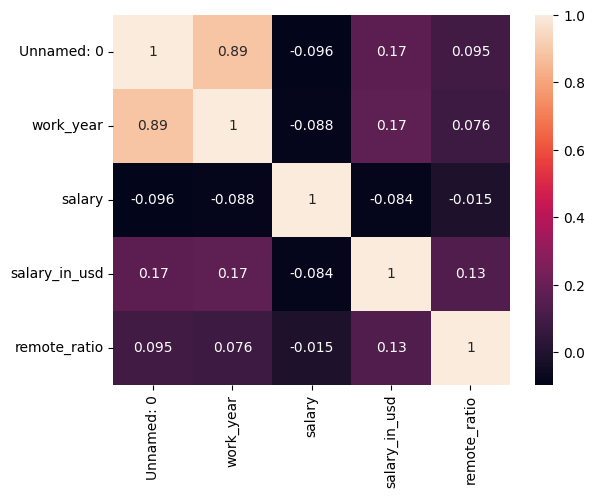

In [202]:
sns.heatmap(hr_agency_df.corr(), annot=True)

In [203]:
hr_agency_df.drop('Unnamed: 0', axis=1, inplace=True)

* В датасете отсутствуют пропуски и дубликаты. 

* К категориальным признакам можно отнести work_year,experience_level, employment_type, job_title, salary_currency, employee_residence, remote_ratio, company_location, company_size. 
* К числовым: salary, salary_in_usd.

Преобразуем признаки к типу данных *category*:

In [205]:
for col in hr_agency_df.columns:
    if col != 'salary' and col != 'salary_in_usd':
        hr_agency_df[col] = hr_agency_df[col].astype('category')

Для лучшей визуализации добавляем признак 'Размер компании', который идентичен признаку 'company_size'

In [206]:
def company_size(size):
    if size == 'L':
        return 'Крупная компания'
    elif size == 'M':
        return 'Средняя компания'
    elif size == 'S':
        return 'Небольшая компания'
     
hr_agency_df['Размер компании'] = hr_agency_df['company_size'].apply(company_size)

# Разведывательный анализ данных

Так как в признаке *salary_in_usd* есть выбросы, для построения графиков используется медианное значение признака

In [208]:
fig = px.box(data_frame=hr_agency_df,
             x='salary_in_usd',
             title='Распределение признака "salary_in_usd" ')
fig

## Какие факторы влияют на зарплату специалиста Data Scientist?

### Влияет ли опыт работы на зарплату

In [209]:
ds_job = hr_agency_df[hr_agency_df['job_title'] == 'Data Scientist']
grouped_ff = ds_job.groupby(['experience_level'])['salary_in_usd'].median().to_frame()
grouped_ff = grouped_ff.reset_index()
fig = px.bar(
    data_frame=grouped_ff,
    x='experience_level',
    y='salary_in_usd',
    title='Зависимость зарплаты Data Scientist от опыта работы',
    labels= dict(experience_level ='Опыт работы на должности', salary_in_usd='Медианная зарплата'),
    color='experience_level'
)
newnames = {'EN':'Entry-level/Junior', 'EX': 'Executive-level/Director', 'MI':'Mid-level/Intermediate', 'SE':'Senior-level/Expert'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))

In [210]:
fig = px.box(ds_job, 
             x='salary_in_usd', 
             y= 'experience_level', 
             title='Распределение признака "salary_in_usd" в зависимости от разных опытов работы',
             labels= dict(experience_level ='Опыт работы', salary_in_usd='	Зарплата в долларах США')
             )
fig

### Влияет ли зарплата от типа трудоустройства

In [211]:
grouped_ff = ds_job.groupby(['employment_type'])['salary_in_usd'].median().to_frame()
grouped_ff = grouped_ff.reset_index()
fig = px.bar(
    data_frame=grouped_ff,
    x='employment_type',
    y='salary_in_usd',
    title='Зависимость зарплаты Data Scientist от типа трудоустройства',
    labels= dict(employment_type ='Тип трудоустройства', salary_in_usd='Медианная зарплата'),
    color='employment_type',
    color_discrete_sequence=px.colors.qualitative.Bold
)
newnames = {'PT':'Неполный рабочий день', 'FT': 'Полный рабочий день', 'CT':'Контракт', 'FL':'Фриланс'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

In [177]:
grouped_ff = ds_job.groupby(['work_year'])['salary_in_usd'].median().to_frame()
grouped_ff = grouped_ff.reset_index()
fig = px.bar(
    data_frame=grouped_ff,
    x='work_year',
    y='salary_in_usd',
    title='Изменения зарплаты специалистов Data Scientist',
    labels= dict(work_year = 'Год', salary_in_usd='Медианная зарплата'),
    color='work_year'
)
fig.update_xaxes(type='category', categoryorder='category ascending')
fig

### Соотношение зарплаты Data Scientist и Data Engineer в 2022 году?

In [212]:
hr_agency_df_22 = hr_agency_df[(hr_agency_df['work_year'] == 2022) & (hr_agency_df['job_title'].isin(['Data Engineer','Data Scientist']))].copy()
hr_agency_df_22['job_title'] = hr_agency_df_22['job_title'].cat.remove_unused_categories()
grouped_ff = hr_agency_df_22.groupby('job_title')['salary_in_usd'].median().to_frame()
grouped_ff = grouped_ff.reset_index()

fig = px.bar(
    data_frame=grouped_ff,
    x='job_title',
    y='salary_in_usd',
    title='Соотношение зарплаты Data Scientist и Data Engineer в 2022 году',
    labels= dict(job_title = 'Роль, в которой соискатель работал в течение года', salary_in_usd='Медианная зарплата'),
    color='job_title'
)
fig.update_xaxes(type='category', categoryorder='category ascending')
fig

### Cоотношение зарплаты специалистов Data Scientist в компаниях различных размеров

In [213]:
grouped_ff = ds_job.groupby('Размер компании')['salary_in_usd'].median().to_frame()
grouped_ff = grouped_ff.reset_index()

fig = px.bar(
    data_frame=grouped_ff,
    x='Размер компании',
    y='salary_in_usd',
    title='Cоотношение зарплаты специалистов Data Scientist в компаниях различных размеров',
    labels= dict(company_size = 'Среднее количество людей, работавших в компании в течение года', salary_in_usd='Медианная зарплата'),
    color='Размер компании',
    color_discrete_sequence=px.colors.qualitative.G10,
)
newnames = {'Крупная компания':'Более 250 сотрудников', 'Средняя компания': 'От 50 до 250 сотрудников', 'Небольшая компания':'Mенее 50 сотрудников'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))
fig

### Cвязь между наличием должностей Data Scientist и Data Engineer и размером компании

In [214]:
hr_ds_de = hr_agency_df[hr_agency_df['job_title'].isin(['Data Engineer','Data Scientist'])].copy()
hr_ds_de['job_title'] = hr_ds_de['job_title'].cat.remove_unused_categories()
cnt_job_comp = hr_ds_de.groupby(['job_title', 'company_size'])['Размер компании'].count().unstack()
fig = px.bar(cnt_job_comp,
            title='Cвязь между наличием должностей Data Scientist и Data Engineer и размером компании',
            labels= dict(job_title = 'Роль, в которой соискатель работал в течение года', value='Кол-во должностей'),
            color_discrete_sequence=px.colors.qualitative.Set1)
newnames = {'L':'Более 250 сотрудников (крупная компания)', 'M': 'От 50 до 250 сотрудников (средняя компания)', 'S':'Mенее 50 сотрудников (небольшая компания)'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))
fig

Выводы по разведывательному анализу:

* Опыт работы и тип трудоустройства влияют на зарплату специалиста Data Scientist

* Наблюдается ежегодный рост зарплат у специалистов Data Scientist

* В 2022 году зарплата у Data Scientist выше, чем у Data Engineer

* Data scientist, работающий в средней компании, в среднем имеет самую высокую зп. Но самый высокооплачиваемый специалист работает в крупной компании
* Специалисты Data Scientist и Data Engineer преимущественно имеют должности в средних компаниях. Стоит отметить, что распределение по количеству должностей от размера компании одинаковое у обоих деятельностей

# Статистический анализ данных

In [215]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
        

### Влияет ли опыт работы на зарплату Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: опыт работы не влияет на зарплату: Entry-level/Junior ($μ_1$), Mid-level/Intermediate ($μ_2$), Senior-level/Expert ($μ_3$)

$$ H_0 : μ_1 = μ_2 = μ_3 $$

*Альтернативная гипотеза*: опыт работы влияет на зарплату: Entry-level/Junior ($μ_1$), Mid-level/Intermediate ($μ_2$), Senior-level/Expert ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 $$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [218]:
en = ds_job.loc[ds_job['experience_level'] == 'EN', 'salary_in_usd']
mi = ds_job.loc[ds_job['experience_level'] == 'MI', 'salary_in_usd']
se= ds_job.loc[ds_job['experience_level'] == 'SE', 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Для Entry-level/Junior:')
result = stats.shapiro(en)
decision_normality(result[1])

print('Mid-level/Intermediate:')
result = stats.shapiro(mi)
decision_normality(result[1])

print('Senior-level/Expert:')
result = stats.shapiro(se)
decision_normality(result[1])


Для Entry-level/Junior:
p-value = 0.174
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Mid-level/Intermediate:
p-value = 0.178
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Senior-level/Expert:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака 'salary_in_usd' ? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [219]:
_, p = stats.kruskal(en, mi, se)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Есть основания утверждать, что опыт работы влияет на зарплату.

### Влияет ли тип трудоустройства на зарплату Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: тип трудоустройства не влияет на зарплату: PT — неполный рабочий день ($μ_1$), FT — полный рабочий день ($μ_2$), FL — фриланс ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*: тип трудоустройства влияет на зарплату: PT — неполный рабочий день ($μ_1$), FT — полный рабочий день ($μ_2$), FL — фриланс ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка нельзя полностью проверить признак, так как недостаточно данных для каждого праметра признака 'employment_type', поэтому воспользуемся графиком Q-Q plot.

In [220]:
ft = ds_job.loc[ds_job['employment_type'] == 'FT', 'salary_in_usd']
pt = ds_job.loc[ds_job['employment_type'] == 'PT', 'salary_in_usd']
fl = ds_job.loc[ds_job['employment_type'] == 'FL', 'salary_in_usd']
result = stats.shapiro(ft)
decision_normality(result[1])

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Text(0.5, 1.0, 'Квантиль-квантиль график \n для распределения зарплаты в зависимости от графика работы')

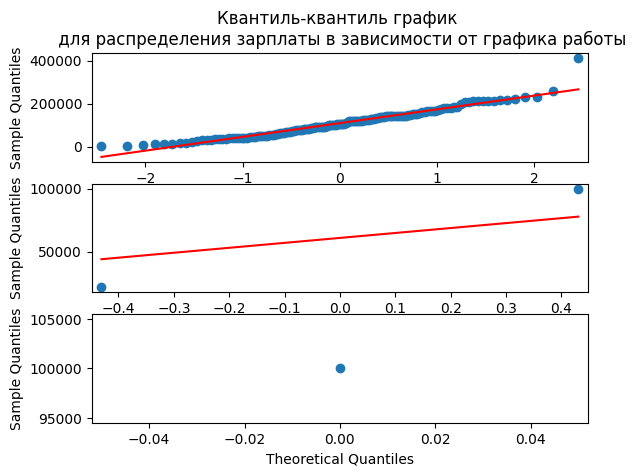

In [221]:
fig, axes = plt.subplots(nrows=3)
FT = sm.qqplot(ds_job.loc[ds_job['employment_type'] == 'FT', 'salary_in_usd'], line='s', ax=axes[0])
PT = sm.qqplot(ds_job.loc[ds_job['employment_type'] == 'PT', 'salary_in_usd'], line='s', ax=axes[1])
FL = sm.qqplot(ds_job.loc[ds_job['employment_type'] == 'FL', 'salary_in_usd'], line='s', ax=axes[2])
#sm.qqplot(ds_job.loc[ds_job['employment_type'] == 'PT', 'salary_in_usd'], line='s')
axes[0].set_title('Квантиль-квантиль график \n для распределения зарплаты в зависимости от графика работы')


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака 'salary_in_usd' ? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [222]:
_, p = stats.kruskal(ft, pt, fl)
decision_hypothesis(p)

p-value = 0.522
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Нету основания утверждать, что тип трудоустройства влияет на зарплату ,возможно, это из-за недостаточного количества данных.

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: Отсутствует ежегодный рост зарплат у специалистов Data Scientist: 2020 ($μ_1$), 2021 ($μ_2$), 2022 ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*: Есть ежегодный рост зарплат у специалистов Data Scientist: 2020 ($μ_1$), 2021 ($μ_2$), 2022 ($μ_3$).


$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [223]:
year_20 = ds_job.loc[ds_job['work_year'] == 2020, 'salary_in_usd']
year_21 = ds_job.loc[ds_job['work_year'] == 2021, 'salary_in_usd']
year_22 = ds_job.loc[ds_job['work_year'] == 2022, 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для 2020:')
result = stats.shapiro(year_20)
decision_normality(result[1])

print('Для 2021:')
result = stats.shapiro(year_21)
decision_normality(result[1])

print('Для 2022:')
result = stats.shapiro(year_22)
decision_normality(result[1])

Для 2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2021:
p-value = 0.125
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2022:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


In [224]:
result = stats.shapiro(year_20)
decision_normality(result[1])

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака 'salary_in_usd' ? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [225]:
_, p = stats.kruskal(year_20, year_21, year_22)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Есть основания утверждать, что c каждым годом зарплата Data Scientist увеличивается.

### Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: зарплата Data Engineer больше или равна зарплате Data Scientist : Data Engineer ($μ_1$), Data Scientist ($μ_2$).

$$ H_0 : μ_1 >= μ_2 $$

*Альтернативная гипотеза*: зарплата Data Scientist больше зарплаты Data Engineer: Data Engineer ($μ_1$), Data Scientist ($μ_2$).


$$ H_1 : μ_1 < μ_2 $$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [226]:
job_ds = hr_agency_df_22.loc[hr_agency_df_22['job_title'] == 'Data Scientist', 'salary_in_usd']
job_de = hr_agency_df_22.loc[hr_agency_df_22['job_title'] == 'Data Engineer', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для Data Scientist:')
result = stats.shapiro(job_ds)
decision_normality(result[1])

print('Для Data Engineer:')
result = stats.shapiro(job_de)
decision_normality(result[1])

Для Data Scientist:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для Data Engineer:
p-value = 0.010
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака 'salary_in_usd' ? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Манна-Уитни.

**Проведём тест**

In [227]:
p = stats.mannwhitneyu(x=job_de, y=job_ds, alternative='less')
decision_hypothesis(p[1])

p-value = 0.077
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Нету оснований утверждать, что зарплата Data Scientist больше зарплаты Data Engineer.

### Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: зарплаты в компаниях различных размеров одинаковые: небольшая компания ($μ_1$), средняя компания ($μ_2$), крупная компания ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3 $$

*Альтернативная гипотеза*: зарплаты в компаниях различных размеров не одинаковые: небольшая компания ($μ_1$), средняя компания ($μ_2$), крупная компания ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 $$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [228]:
s = ds_job.loc[ds_job['company_size'] == 'S', 'salary_in_usd']
m = ds_job.loc[ds_job['company_size'] == 'M', 'salary_in_usd']
l= ds_job.loc[ds_job['company_size'] == 'L', 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Для небольшой компании:')
result = stats.shapiro(s)
decision_normality(result[1])

print('Для средней компании:')
result = stats.shapiro(m)
decision_normality(result[1])

print('Для крупной компании:')
result = stats.shapiro(l)
decision_normality(result[1])


Для небольшой компании:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для средней компании:
p-value = 0.639
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для крупной компании:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака 'salary_in_usd' ? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [229]:
_, p = stats.kruskal(s, m, l)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Есть основания утверждать, что размер компании влияет на зарплату.

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: нету взаимосвязи между должностями Data Scientist и Data Engineer и размером компании (признаки независимы).

*Альтернативная гипотеза*: есть взаимосвязь между должностями Data Scientist и Data Engineer и размером компании (признаки независимы) (признаки зависимы).

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «company_size»? — Категориальный.
* Сколько сравниваемых групп? — Две.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [230]:
# составляем таблицу сопряжённости
cross_table = pd.crosstab(hr_ds_de['job_title'], hr_ds_de['company_size'])

cross_table

company_size,L,M,S
job_title,,,
Data Engineer,37,89,6
Data Scientist,45,77,21


In [231]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.008
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Существует статистически значимая взаимосвязь должностями Data Scientist и Data Engineer и размером компании.

## Итоговые результаты исследования

* Есть основания утверждать, что опыт работы влияет на зарплату.
* Нету основания утверждать, что тип трудоустройства влияет на зарплату ,возможно, это из-за недостаточного количества данных.
* Есть основания утверждать, что c каждым годом зарплата Data Scientist увеличивается.
* Есть основания утверждать, что размер компании влияет на зарплату.
* Нету оснований утверждать, что зарплата Data Scientist больше зарплаты Data Engineer.
* Существует статистически значимая взаимосвязь должностями Data Scientist и Data Engineer и размером компании.